In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar
from scipy.stats import linregress, gamma
from imageio import imread
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import os
from collections import namedtuple
from copy import copy
from outbreak_modelling import *
from jhdatautils import *
sns.set(style='white')

## John-Hopkins data

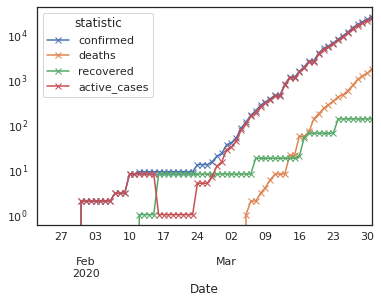

In [3]:
data = load_data()
ts = single_country_data(data, 'United Kingdom', ('2020/03/01', '2020/03/16'))
ts.to_csv('simdata/uk-observations-used-for-simulation.csv')
ts.plot(marker='x')
plt.yscale('log')

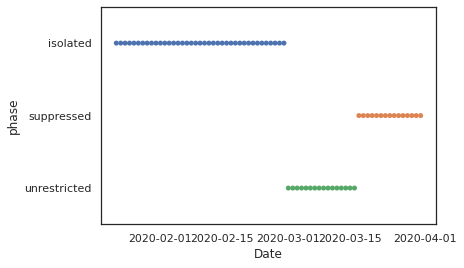

In [4]:
sns.stripplot(data=ts, x=ts.index, y='phase', jitter=0)

In [5]:
def estimate_growth_lr(data, column):
    data = data.copy()[column]
    data = np.log(data[data>0])
    x = (data.index - data.index[0]).to_series().dt.days.values
    y = data.values
    c, _, _, _, _ = linregress(x, y)
    return np.exp(c)-1

c_growth = estimate_growth_lr(ts[ts['phase']=='unrestricted'], 'confirmed')
d_growth = estimate_growth_lr(ts[ts['phase']=='unrestricted'], 'deaths')
print('Cases growth rate: {:.2%}'.format(c_growth))
print('Deaths growth rate: {:.2%}'.format(d_growth))

Cases growth rate: 28.60%
Deaths growth rate: 36.49%


## The model

How does R_0 vary as you change the fraction of the mean generation time that is latent?

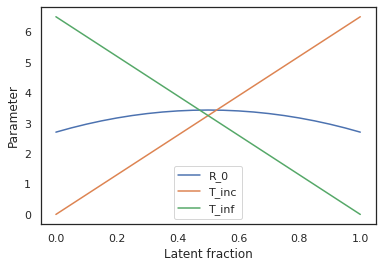

In [6]:
def plot_R_0_dependence(early_growth_rate, mean_generation_time):
    xs = np.linspace(0, 1, 21)
    ys = {lf: pd.Series(calibrate_transmission_model(early_growth_rate,
                                                 mean_generation_time,
                                                 lf),
                    name=lf) for lf in xs}
    df = pd.DataFrame(ys).T
    df.plot()
    plt.xlabel('Latent fraction')
    plt.ylabel('Parameter')
    
plot_R_0_dependence(0.3, 6.5)

These are the SEIR parameter we will use:

In [7]:
calibrate_transmission_model(0.3, 6.5, 0.71)

{'R_0': 3.30418237690366, 'T_inc': 4.615, 'T_inf': 1.8849999999999998}

Define a function for plotting simulation results...

In [37]:
def plot_simulation(sim, transmission_model, ts):
    n_plots = 2
    f, axs = plt.subplots(n_plots, 1, figsize=(12, 6*n_plots), squeeze=False)
    axs = axs.ravel()
    sim[['All admissions', 'Active cases', 'All deaths', 'Daily deaths', 'E', 'I']].plot(ax=axs[0])
    ts[['confirmed', 'deaths']].plot(marker='x', linestyle=':',ax=axs[0])
    axs[0].set_yscale('log')
    axs[0].set_ylim(1, None)
    (np.exp(sim.E / sim.I / transmission_model.T_inc - 1./transmission_model.T_inf)-1).rename('I growth').plot(ax=axs[1])
    #(sim.I.diff() / (0.5*(sim.I.shift(1) + sim.I.shift(1)))).rename('debug').plot(ax=axs[1])
    axs[1].set_ylim(-0.2, 0.4)
    axs[1].axhline(0.3, color='r', linestyle=':')
    for ax in axs:
        ax.legend()
        ax.set_xlabel('Date')

Original Ferguson Model

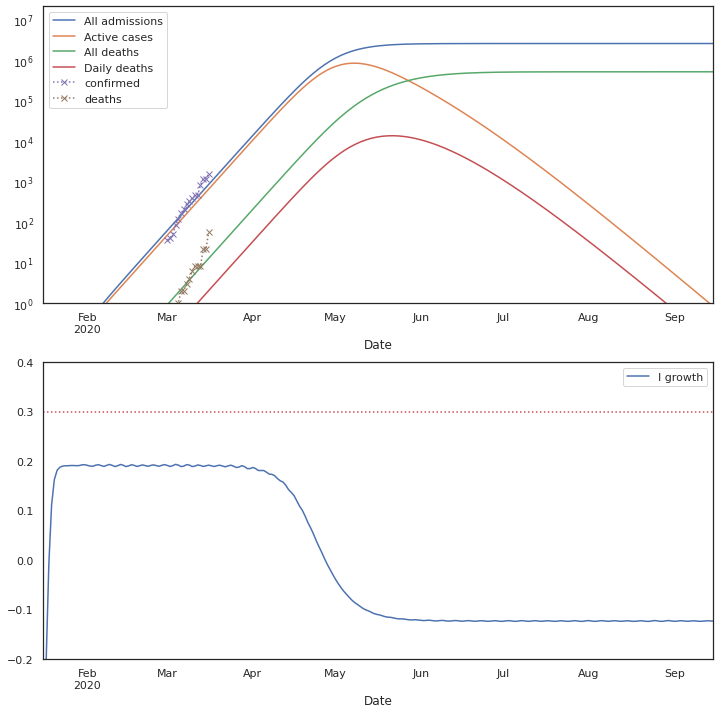

In [9]:
transmission_parameters = calibrate_transmission_model(0.3, 6.5, 0.71)
t_model = SEIRModel(**transmission_parameters)
e_model = EmissionModel(f_hosp=0.044, f_death=0.2,
                        n_hosp=4, T_hosp=11,
                        n_resolve=9, T_resolve=8,
                        n_death=4, T_death=21)
t_model.R_0 = lambda _: 2.4
sim_orig = run_outbreak(t_model, e_model, 2*365//3, make_state(S=6.64e7, I=1))
sim_orig = calibrate_timing_to_cases(sim_orig,
                         ts.confirmed[ts['phase']=='unrestricted'])
sim_orig.to_csv('simdata/sim-original-Ferguson-parameters.csv')
plot_simulation(sim_orig, t_model, ts[ts['phase']=='unrestricted'])

How do daily deaths from this model compare to the Ferguson paper?

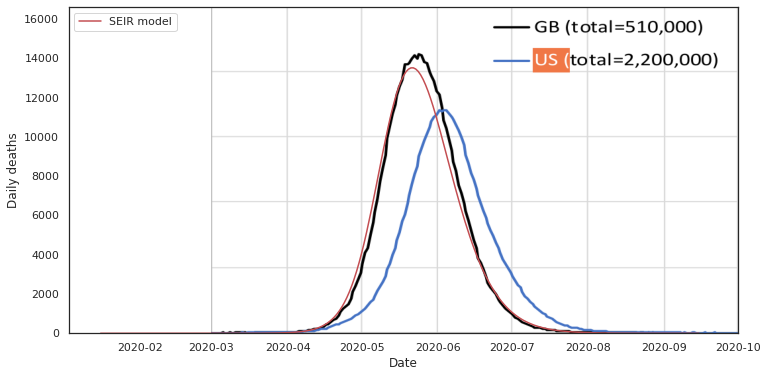

In [10]:
f, ax_d = plt.subplots(1, 1, figsize=(12, 6))
ax_d.imshow(imread('ferguson-plots/deaths.png'),
            extent=(mdates.datestr2num('2020/03/01'),
                    mdates.datestr2num('2020/10/01'), 0., 66400000*25/100000), aspect='auto')
ax_d.xaxis_date()
ax_d.plot(sim_orig.index.to_series().apply(mdates.date2num).values,
          sim_orig['Daily deaths'].values,
          'r', label='SEIR model')
ax_d.legend(loc='upper left')
ax_d.set_xlabel('Date')
ax_d.set_ylabel('Daily deaths');

In [11]:
print('Final infected proportion: {:.0%}'.format(1. - sim_orig['S'].iloc[-1] / sim_orig['S'].iloc[0]))
print('Final number of deaths: {:,.0f}'.format(sim_orig['All deaths'].iloc[-1]))

Final infected proportion: 88%
Final number of deaths: 513,382


Now, the original Ferguson R_0 was calibrated to the Wuhan outbreak and yields too slow a growth rate to fit UK observations well. Let's fix this by increasing R_0:

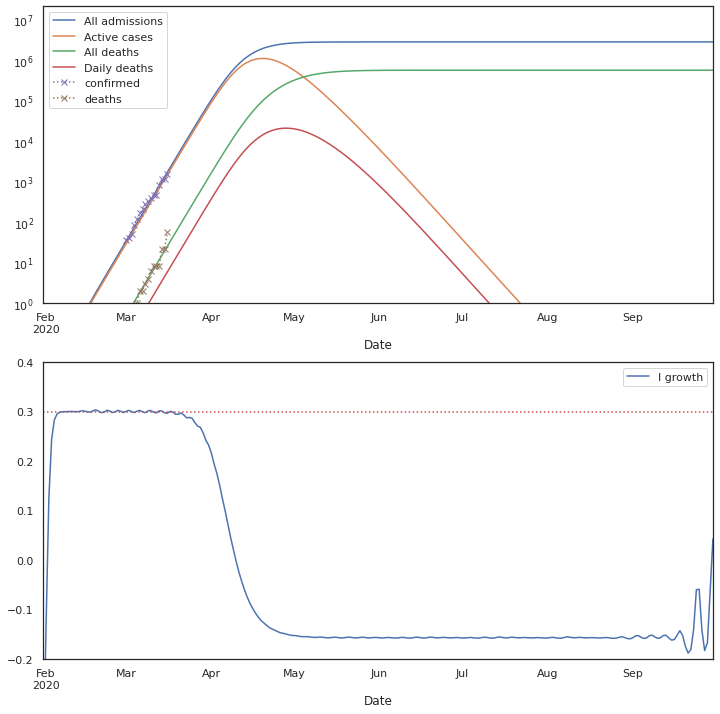

In [14]:
transmission_parameters = calibrate_transmission_model(0.3, 6.5, 0.71)
t_model_c = SEIRModel(**transmission_parameters)
e_model_c = EmissionModel(f_hosp=0.044, f_death=0.2,
                          n_hosp=4, T_hosp=11,
                          n_resolve=9, T_resolve=8,
                          n_death=4, T_death=14)
sim_correct_R_0 = run_outbreak(t_model_c, e_model_c, 2*365//3, make_state(S=6.64e7, I=1))
sim_correct_R_0 = calibrate_timing_to_cases(sim_correct_R_0,
                         ts.confirmed[ts['phase']=='unrestricted'])
sim_correct_R_0.to_csv('simdata/sim-R_0-3.3-baseline-parameters.csv')
plot_simulation(sim_correct_R_0, t_model_c, ts[ts['phase']=='unrestricted'])

Compare the two models:

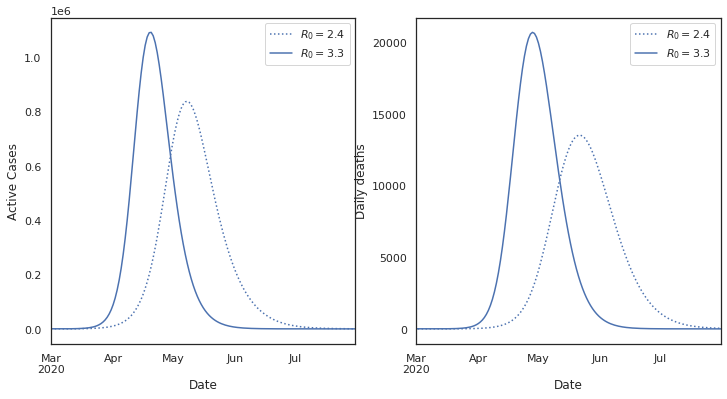

In [15]:
f, (ax_a, ax_d) = plt.subplots(1, 2, figsize=(12,6))
plt.sca(ax_a)
sim_orig['Active cases'].rename('$R_0 = 2.4$').plot(ax=plt.gca(), color='b', ls=':')
sim_correct_R_0['Active cases'].rename('$R_0 = 3.3$').plot(ax=plt.gca(), color='b')
plt.legend()
plt.ylabel('Active Cases')
plt.xlim('2020/03/01', '2020/07/31')
plt.sca(ax_d)
sim_orig['Daily deaths'].rename('$R_0 = 2.4$').plot(ax=plt.gca(), color='b', ls=':')
sim_correct_R_0['Daily deaths'].rename('$R_0 = 3.3$').plot(ax=plt.gca(), color='b')
plt.legend()
plt.ylabel('Daily deaths')
plt.xlim('2020/03/01', '2020/07/31');

Increasing the $R_0$ yields a better fit but also brings the peak of the outbreak earlier (and increases its severity).

## Simulate lockdown

We assume $R_0$ linearly declines from around 10 March to 26 March. First need to convert that back to simulation time.

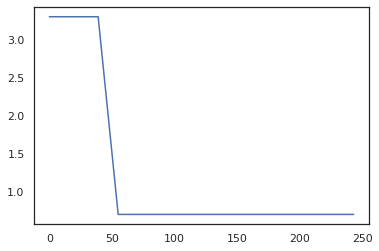

In [55]:
ld_start = (pd.to_datetime('2020/03/10') - sim_correct_R_0.index[0]).days
ld_end = (pd.to_datetime('2020/03/26') - sim_correct_R_0.index[0]).days
R0_final = 0.7
R0_ld = lambda t: np.interp(t, [ld_start, ld_end], [t_model_c.R_0(0), R0_final])
plt.plot(range(len(sim_correct_R_0)), R0_ld(range(len(sim_correct_R_0))))

And then we simulate the outbreak assuming this profile for $R_0$:

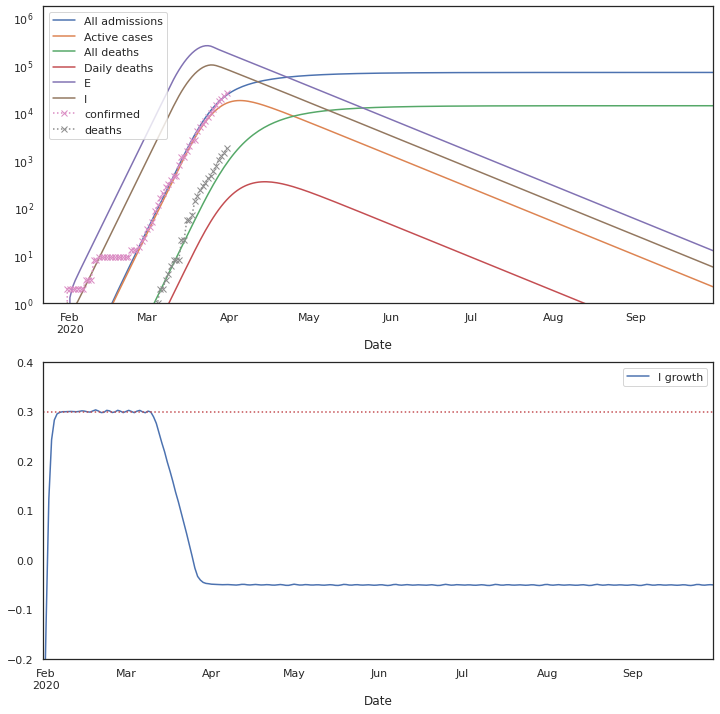

In [56]:
t_model_ld = copy(t_model_c)
t_model_ld.R_0 = R0_ld
sim_ld = run_outbreak(t_model_ld, e_model_c, 2*365//3, make_state(S=6.64e7, I=1))
sim_ld = calibrate_timing_to_cases(sim_ld,
                                   ts.confirmed[ts['phase']=='unrestricted'])
assert ((sim_correct_R_0.index - sim_ld.index).to_series().dt.days==0).all()
sim_ld.to_csv('simdata/sim-lockdown-final-R0-{}.csv'.format(R0_final))
plot_simulation(sim_ld, t_model_ld, ts)

Actually, it seems that in mid-March cumulative deaths jumped up (from media articles it sounds like this is related to delayed reporting of earlier deaths). Need to have a think about how to best incorporate this, but in any case, reducing $T_{death}$ to around 10 days seems to be a better fit to recent data.

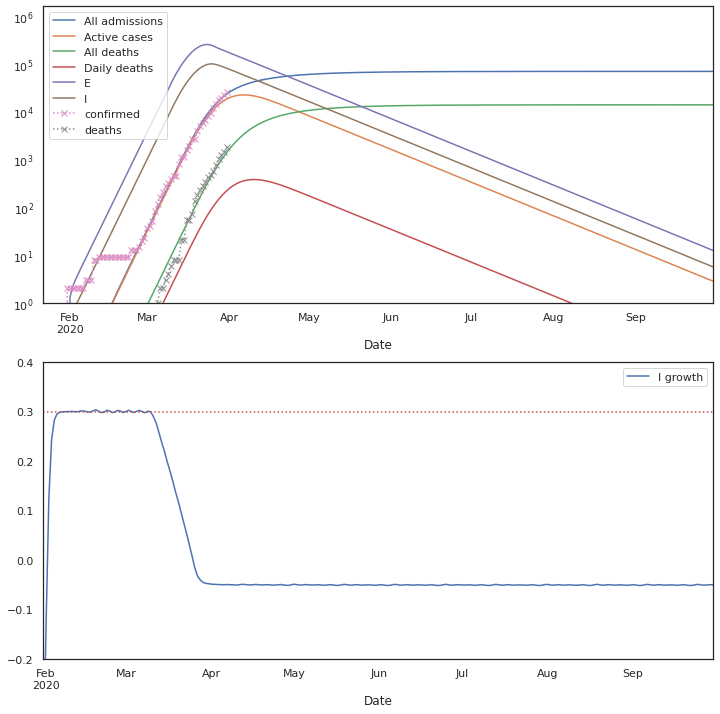

In [57]:
ld_T_death = 10
e_model_ld = EmissionModel(f_hosp=0.044, f_death=0.2,
                          n_hosp=4, T_hosp=11,
                          n_resolve=9, T_resolve=12,
                          n_death=4, T_death=ld_T_death)
sim_ld = run_outbreak(t_model_ld, e_model_ld, 2*365//3, make_state(S=6.64e7, I=1))
sim_ld = calibrate_timing_to_cases(sim_ld,
                                   ts.confirmed[ts['phase']=='unrestricted'])
assert ((sim_correct_R_0.index - sim_ld.index).to_series().dt.days==0).all()
sim_ld.to_csv('simdata/sim-lockdown-final-R0-{}-T_death-{}.csv'.format(R0_final, ld_T_death))
plot_simulation(sim_ld, t_model_ld, ts)